# Local Depth Exploration

In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import progressbar

In the Geenens manuscript, depth at a point $x$ is quantified by the following (Equation 3.1):
\begin{equation}
   DD(x,P) = P(d(X_1, X_2) > \max(d(x,X_1), d(x,X_2)))
\end{equation}
This can be thought of as quantifying "inclusion," i.e., if $x$ is "between" the randomly chosen $X_1$ and $X_2$, then the distance from $X_1$ to $X_2$ will be greater than both the distance from $x$ to $X_1$ and the distance from $x$ to $X_2$.

The focus on local depth is less on being "between" observations from $P$, but on being "close" to random draws from $P$. For example, in the canonical univariate, bimodal example, draws from $P$ are more likely to be close to either of the modes.

So, the idea here is to try to quantify local depth by balancing these two effects. Just as the local depth paper you shared has a tuning parameter, here the tuning parameter is a factor which balances these two contributions.

This just illustrates a simple example. Generate the random sample.

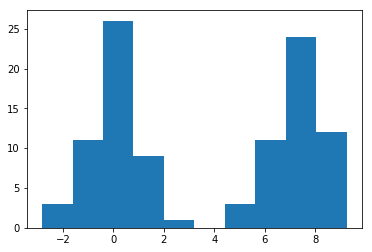

In [2]:
nsim = 100
xsim = norm.rvs(size=nsim)
xsim = np.concatenate((norm.rvs(size=int(nsim/2)), norm.rvs(7,size=int(nsim/2))),axis=None)
plt.hist(xsim)
plt.show()

Set the target point(s), the value(s) at which the depth will be calculated.

In [3]:
xtarget = np.arange(round(min(xsim)),round(max(xsim)),.2)

The value of `alpha` controls the weight placed on the two components: Larger `alpha` puts more weight on "proximity" relative to "inclusion."

In [4]:
alpha = 10

In [5]:
pos = 0
holddepth = np.zeros(len(xtarget))
for xt in xtarget:
    hold1 = 0
    for i in range(nsim):
        for j in range(i):
            dist1 = abs(xsim[i]-xsim[j])
            dist2 = abs(xt - xsim[i])
            dist3 = abs(xt - xsim[j])
            holddepth[pos] = holddepth[pos] + (dist1 > max(dist2,dist3)) + alpha*np.exp(-min(dist2,dist3))
    pos +=1

## Just quantify what this is doing mathematically:


### Probablistically:

Geenen's:
$$
𝐷𝐷(𝑥,𝑃)=𝑃[𝑑(𝑋1,𝑋2)>max(𝑑(𝑥,𝑋1),𝑑(𝑥,𝑋2))]
$$

Schafer's:
$$
DD_\alpha(x,P) = 𝐷𝐷(𝑥,𝑃) + \alpha \mathbb{E}[e^{-min(𝑑(𝑥,𝑋1),𝑑(𝑥,𝑋2)}]
$$

### Empirically:

Geenen's:
$$
𝐷𝐷(𝑥,\hat{P})= \frac{1}{n \choose 2}\sum_{i\neq j}[𝑑(𝑋_i,𝑋_j)>max(𝑑(𝑥,𝑋_i),𝑑(𝑥,𝑋_j))] 
$$

Schafer's:
$$
DD_\alpha(x,P) = 𝐷𝐷(𝑥,\hat{P}) + \alpha \frac{1}{n \choose 2}\sum_{i\neq j}(e^{-min(𝑑(𝑥,𝑋_j),𝑑(𝑥,𝑋_i)})
$$




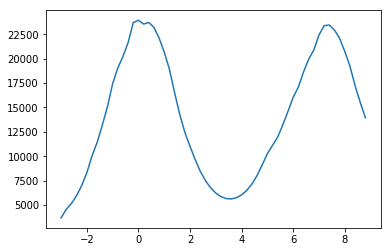

In [6]:
plt.plot(xtarget,holddepth)
plt.show()

# Data Depth Attempt

I'm just very used to "Data Depth" being defined more close to the depth of actual points in the space. Though I see that your definition can quickly give you depth for points not in the space.

In [7]:
pos = 0
holddepth_sim = np.zeros(len(xsim))
for xt in xsim:
    hold1 = 0
    for i in range(nsim):
        for j in range(i):
            dist1 = abs(xsim[i]-xsim[j])
            dist2 = abs(xt - xsim[i])
            dist3 = abs(xt - xsim[j])
            holddepth_sim[pos] = holddepth_sim[pos] + (dist1 > max(dist2,dist3)) + alpha*np.exp(-min(dist2,dist3))
    pos +=1

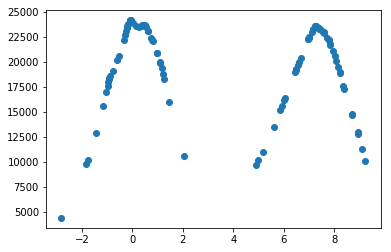

In [8]:
plt.scatter(xsim,holddepth_sim)
plt.show()

# Multi-Dimensional

In [9]:
import scipy.spatial # for distance matrix
# scipy.spatial.distance_matrix

In [10]:
x = np.concatenate([xsim.reshape((-1,1)), np.zeros((xsim.shape[0],1))], axis = 1)
dist_matrix = scipy.spatial.distance_matrix(x = x, y = x)


## Some functions to help with calculation:
Just putting your approach in some functions. (Structure from TC code)

In [11]:
def remove_idx(i,n):
    return np.concatenate([np.arange(i),np.arange(i+1,n)])

In [12]:
def distance_depth_function(dist_matrix, alpha = [0]):
    """
    calculates a depth vector using a distance matrix

    Arguments:
    ----------
    dist_matrix: np.array (n,n)
        square positive symmetric matrix
    alpha : list of non-negative scalars in range [0, 1]
        trades off between "inclusion" and "proximity"

    Returns:
    --------
    depth: np.array (n,) 
        vector with depth values associated with indices in dist_matrix
    """
    N = dist_matrix.shape[0]
    L = len(alpha)
    
    if (N != dist_matrix.shape[1]) or \
        (np.any(dist_matrix.T != dist_matrix)) or \
        (np.any(dist_matrix < 0)):
        stop("this is not a positive symmetric square matrix")

    assert np.all(np.array(alpha) <= 1) and \
        np.all(np.array(alpha) >= 0), \
        "alpha should be between 0 and 1 inclusive."
        
    depth = np.zeros((N, L))
  

    for obs_index in np.arange(N):
        rm_idx = remove_idx(obs_index, N)
        sub_matrix = dist_matrix[rm_idx,][:,rm_idx]
    
        obs_column = dist_matrix[rm_idx,obs_index]
        obs_row    = dist_matrix[obs_index,rm_idx]
    
        obs_column_matrix = np.tile(obs_column, (N - 1,1))
        obs_row_matrix    = np.tile(obs_column, (N - 1,1)).T 
        
        obs_combo_array = np.zeros((N - 1, N - 1, 2))
        obs_combo_array[:,:,0] = obs_column_matrix
        obs_combo_array[:,:,1] = obs_row_matrix

        max_matrix = obs_combo_array.max(axis = 2)

        min_matrix = obs_combo_array.min(axis = 2)

        max_part = np.mean(sub_matrix > max_matrix)
        min_part = np.mean(np.exp(-min_matrix))
        
        depth[obs_index,:] = np.array([(1-alpha_i)*max_part + alpha_i * min_part for alpha_i in alpha])
    return(depth)

### Quick Check of code (visually)

In [13]:
dd_10 = distance_depth_function(dist_matrix, alpha = [.9])

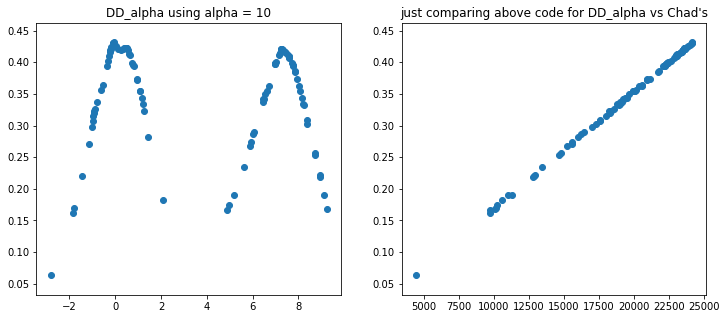

In [14]:
fig, ax = plt.subplots(ncols = 2, figsize = (12,5))
ax[0].scatter(xsim,dd_10.ravel())
ax[0].set_title("DD_alpha using alpha = 10")
ax[1].scatter(holddepth_sim,dd_10.ravel())
ax[1].set_title("just comparing above code for DD_alpha vs Chad's")
plt.show()

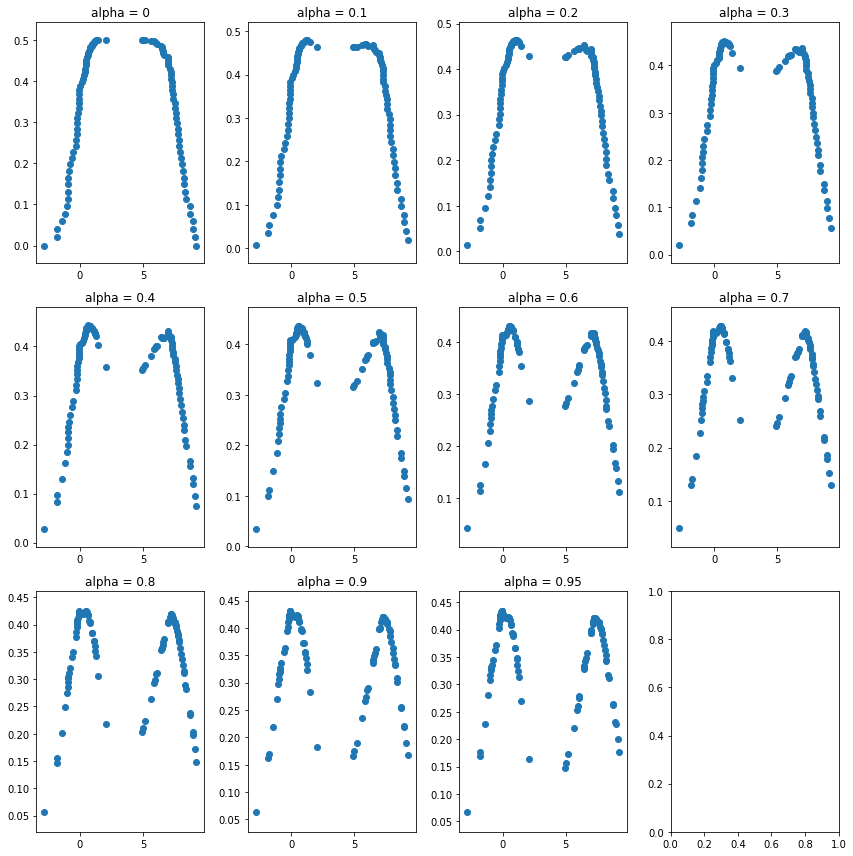

In [15]:
fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize = (12,12))
ax = ax.ravel()

dd2_alpha = distance_depth_function(dist_matrix, 
                                    alpha = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95])
for idx, alpha in enumerate([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95]):
    dd2_alpha_i = dd2_alpha[:,idx]
    ax[idx].scatter(x = xsim, y = dd2_alpha_i)
    ax[idx].set_title("alpha = " + str(alpha))
fig.tight_layout()

### 1D quality check #2

New $X = 10\cdot X$:


The below analysis worries me. We're currently weighting a guassian weight with $\alpha$ but we will probably need to also do a $\sigma$ style scaling to $e^{-min(dist_{ij}, dist_{ik})}$. I think we need to think about this a bit more.

In [16]:
x_larger = np.concatenate([xsim.reshape((-1,1))*10, 
                           np.zeros((xsim.shape[0],1))], axis = 1)
dist_matrix_larger = scipy.spatial.distance_matrix(x = x_larger, 
                                                   y = x_larger)

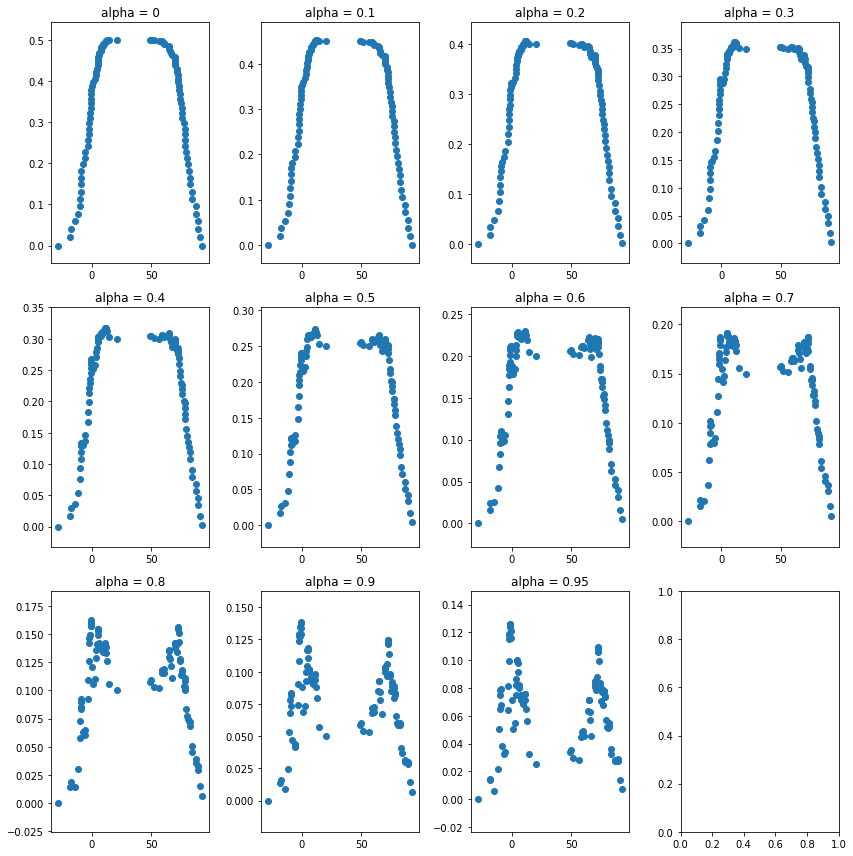

In [17]:
fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize = (12,12))
ax = ax.ravel()

dd2_alpha_larger = distance_depth_function(dist_matrix_larger, 
                                    alpha = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95])
for idx, alpha in enumerate([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95]):
    dd2_alpha_i_larger = dd2_alpha_larger[:,idx]
    ax[idx].scatter(x = x_larger[:,0], y = dd2_alpha_i_larger)
    ax[idx].set_title("alpha = " + str(alpha))
fig.tight_layout()

## Actual examination:

### example 1: 2 gaussians (same variance)

In [18]:
xsim2 = np.random.normal(loc=(0,0), scale=(1,1), size=(100,2))
xsim2 = np.concatenate([xsim2, 
                        np.random.normal(loc=(7,7), 
                                         scale=(1,1), 
                                         size=(100,2))], 
                       axis = 0)

In [19]:
dist2 = scipy.spatial.distance_matrix(xsim2, xsim2)

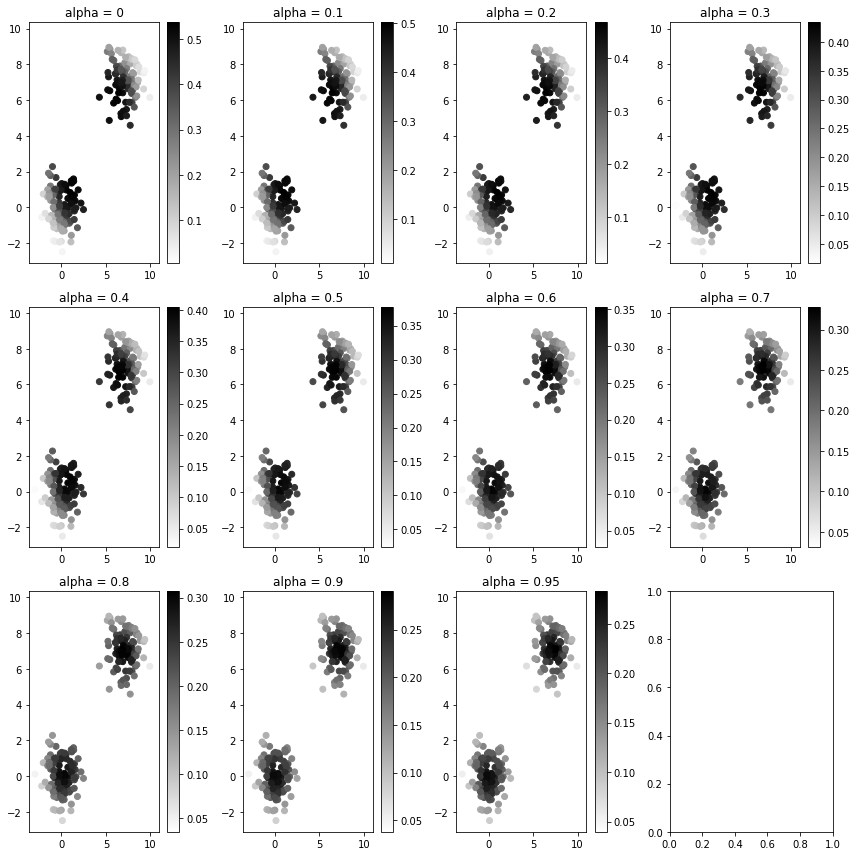

In [20]:
fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize = (12,12))
ax = ax.ravel()

colorstuff = []

dd2_alpha2 = distance_depth_function(dist2, 
                                    alpha = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95])
    
for idx, alpha in enumerate([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95]):
    dd2_alpha_i = dd2_alpha2[:,idx]
    colorstuff.append(ax[idx].scatter(x = xsim2[:,0], y = xsim2[:,1], c = dd2_alpha_i, cmap = 'binary'))
    ax[idx].set_title("alpha = " + str(alpha))
    fig.colorbar(colorstuff[idx], ax = ax[idx])
fig.tight_layout()

### example 2: 2 half moons (same variance)

In [21]:
import sklearn.datasets
n_data = 350*2
X, y = sklearn.datasets.make_moons(n_samples=n_data,
                                   noise=.1)

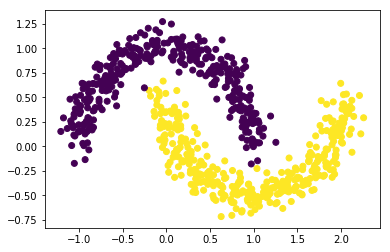

In [22]:
plt.scatter(X[:,0], X[:,1], c = y)

In [23]:
dist3 = scipy.spatial.distance_matrix(X,X)

dd3_alpha = distance_depth_function(dist3, 
                                    alpha = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95])

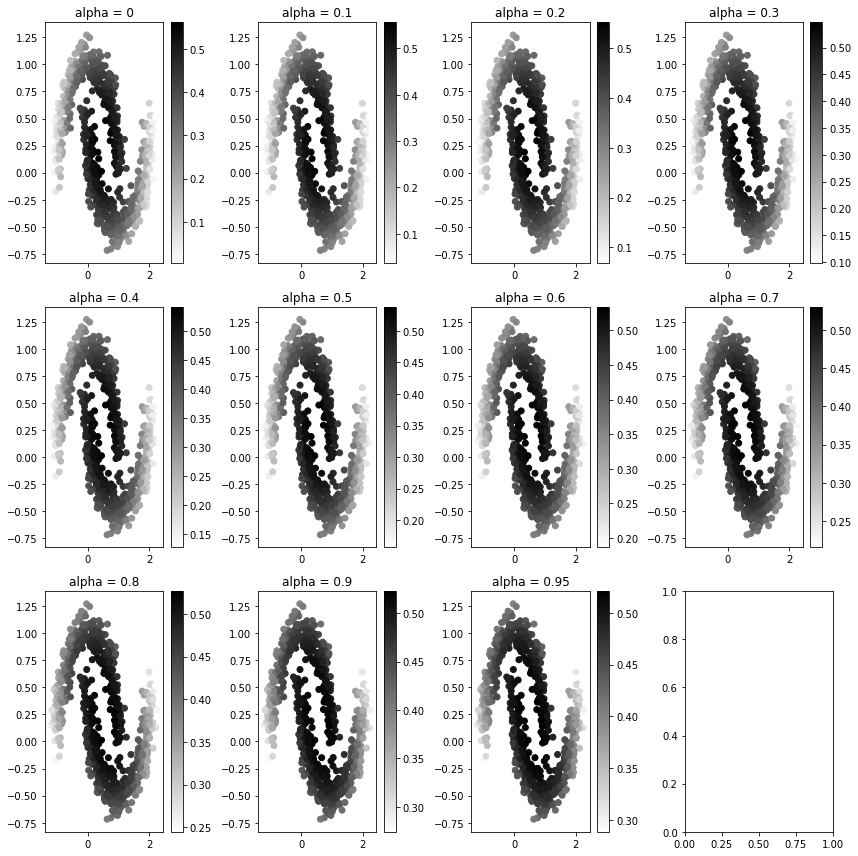

In [24]:
fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize = (12,12))
ax = ax.ravel()


first_iter = enumerate([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95])

colorstuff = []
for idx, alpha in first_iter:
    dd3_alpha_i = dd3_alpha[:,idx]
    colorstuff.append(ax[idx].scatter(x = X[:,0], y = X[:,1], c = dd3_alpha_i, 
                                      cmap = 'binary'))
    ax[idx].set_title("alpha = " + str(alpha))
    fig.colorbar(colorstuff[idx], ax = ax[idx])
fig.tight_layout()

### example 3: 2 guassians, different variance

In [25]:
xsim4 = np.random.normal(loc=(0,0), scale=(.5,.5), size=(100,2))
xsim4 = np.concatenate([xsim4, 
                        np.random.normal(loc=(7,7), 
                                         scale=(1.5,1.5), 
                                         size=(100,2))], 
                       axis = 0)

In [26]:
dist4 = scipy.spatial.distance_matrix(xsim4, xsim4)

In [27]:
dd4_alpha2 = distance_depth_function(dist4, 
                                    alpha = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95])

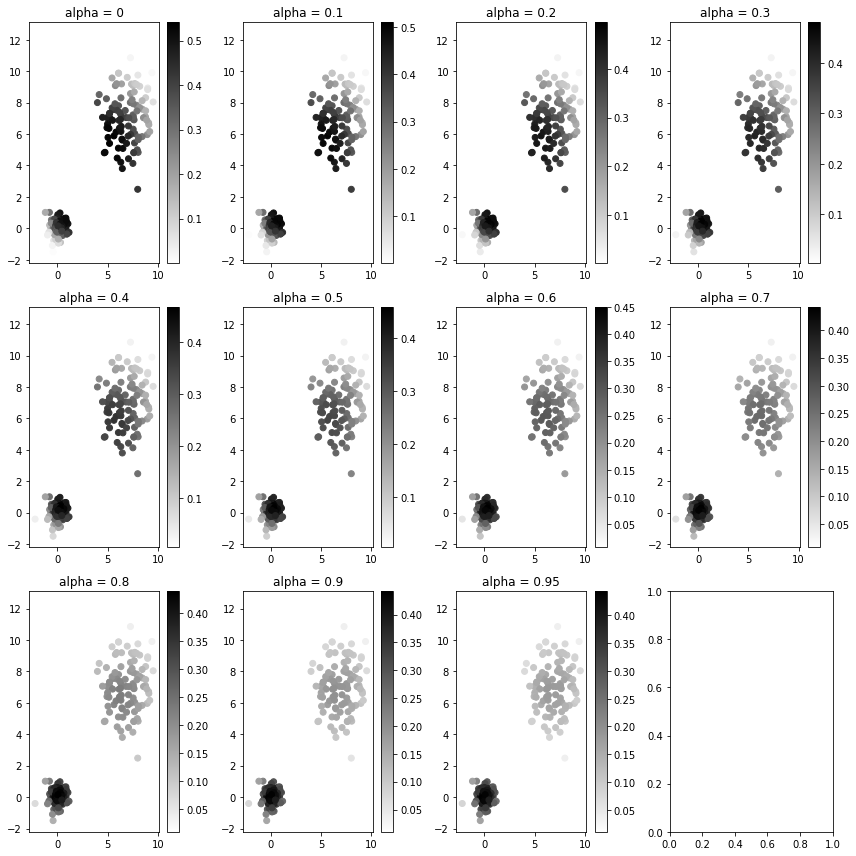

In [28]:
fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize = (12,12))
ax = ax.ravel()

colorstuff = []

for idx, alpha in enumerate([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95]):
    dd4_alpha_i = dd4_alpha2[:,idx]
    colorstuff.append(ax[idx].scatter(x = xsim4[:,0], y = xsim4[:,1], 
                                      c = dd4_alpha_i, cmap = 'binary'))
    ax[idx].set_title("alpha = " + str(alpha))
    fig.colorbar(colorstuff[idx], ax = ax[idx])
fig.tight_layout()

the code below was just a way to find a silly bug above

In [29]:
import progressbar

In [30]:
pos = 0
holddepth_sim = np.zeros(xsim4.shape[0])
bar = progressbar.ProgressBar()
for r_idx in bar(range(xsim4.shape[0])):
    xt = xsim4[r_idx,:]
    hold1 = 0
    for i in range(xsim4.shape[0]):
        for j in range(i):
            dist1 = np.sqrt(np.sum((xsim4[i,:]-xsim4[j,:])**2))
            dist2 = np.sqrt(np.sum((xt-xsim4[i,:])**2))
            dist3 = np.sqrt(np.sum((xt-xsim4[j,:])**2))
            holddepth_sim[pos] = holddepth_sim[pos] + (dist1 > max(dist2,dist3)) + alpha*np.exp(-min(dist2,dist3))
    pos +=1

100% (200 of 200) |######################| Elapsed Time: 0:01:28 Time:  0:01:28


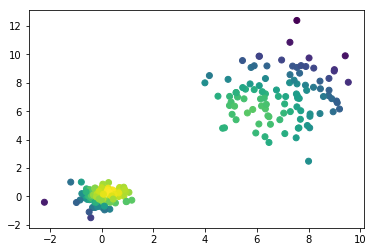

In [31]:
plt.scatter(xsim4[:,0], xsim4[:,1], c = holddepth_sim)